ERROR! Session/line number was not unique in database. History logging moved to new session 72
Warning load w1: cannot convert float NaN to integer
Warning load w2: 'month_num'


C:\Users\nvqua\AppData\Local\Temp\ipykernel_6124\3256078985.py:100: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(d, dayfirst=True)



=== Processing city: Ha Noi ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
City Ha Noi done. RNN MAE=8.698, LSTM MAE=7.461

=== Processing city: Da Nang ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
City Da Nang done. RNN MAE=4.428, LSTM MAE=4.230

=== Processing city: Ho Chi Minh ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
City Ho Chi Minh done. RNN MAE=4.673, LSTM MAE=4.655


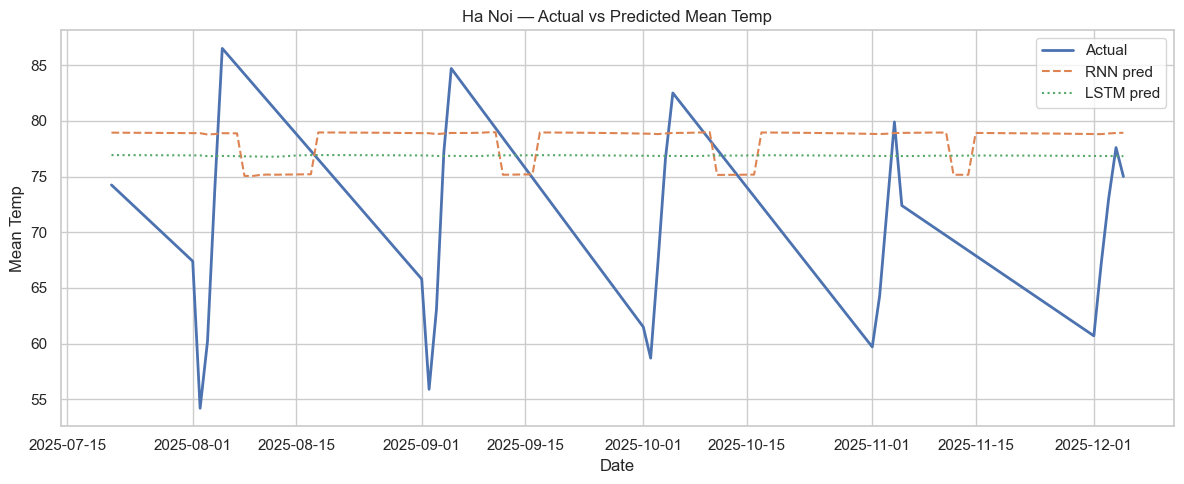

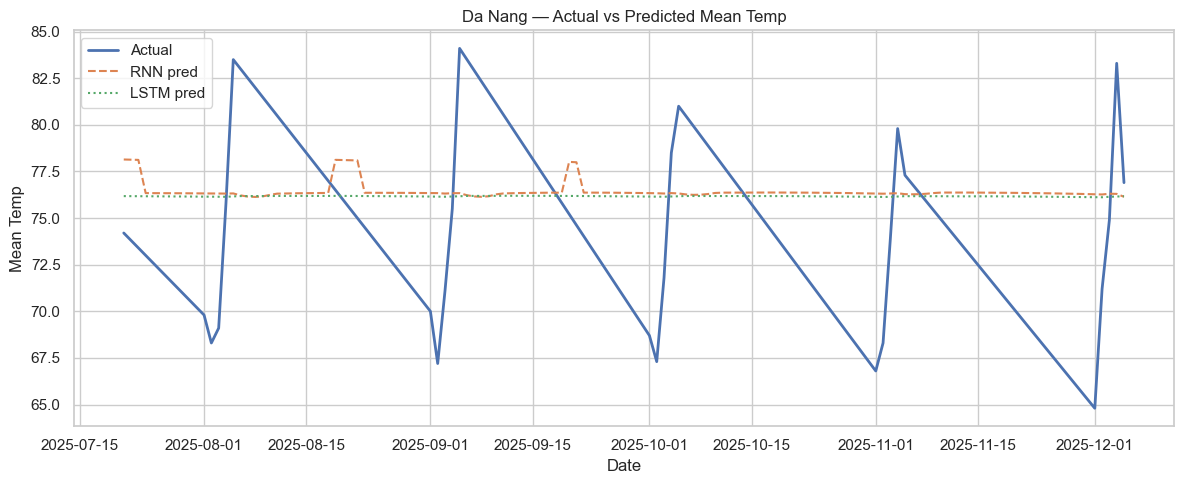

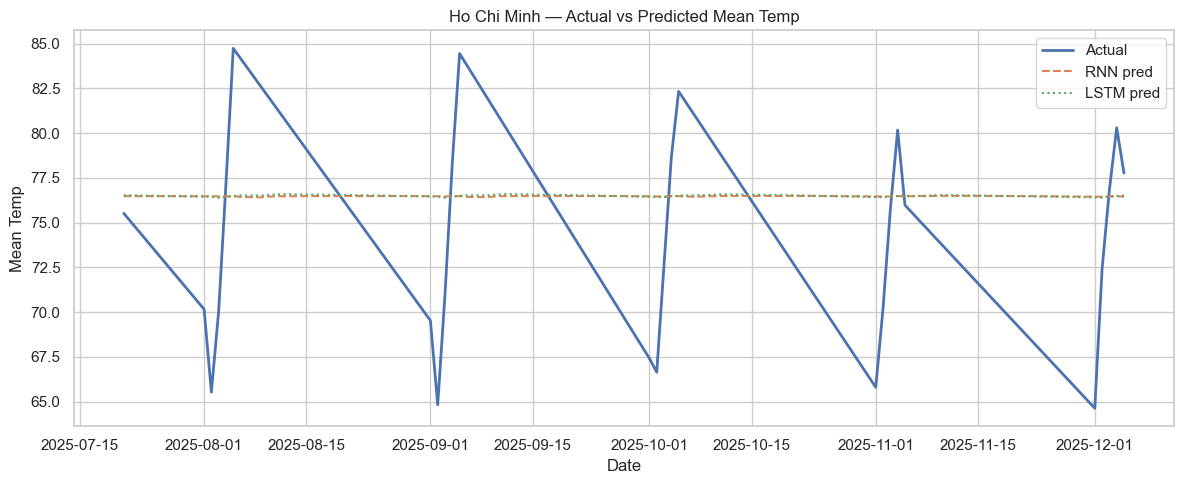


=== Summary metrics ===
                                                   RNN_metrics  \
Ha Noi       {'MAE': 8.697800333095602, 'MSE': 105.30458120...   
Da Nang      {'MAE': 4.4275710373463495, 'MSE': 26.65391991...   
Ho Chi Minh  {'MAE': 4.672851179368688, 'MSE': 30.626424715...   

                                                  LSTM_metrics  
Ha Noi       {'MAE': 7.461365899150143, 'MSE': 78.928444740...  
Da Nang      {'MAE': 4.230128226108333, 'MSE': 25.160378005...  
Ho Chi Minh  {'MAE': 4.655435538358017, 'MSE': 30.411248431...  


In [11]:
# ===========================
# BOX CODE (1 textbox) — Jupyter Notebook + Python 3.11.4 + TensorFlow
# Mục tiêu: Chuẩn hoá 3 file CSV thời tiết, xây RNN & LSTM để dự đoán nhiệt độ hàng ngày
# Dự đoán cho 3 khu vực: "Ha Noi", "Da Nang", "Ho Chi Minh"
# Lưu ý: bạn cần cài đặt môi trường trước khi chạy:
# pip install pandas numpy matplotlib scikit-learn tensorflow seaborn
# ===========================

# 1. Imports & config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

sns.set(style="whitegrid")

# ---------------------------
# 2. Paths to CSVs (chỉ 3 file)
# ---------------------------
path_w1 = "data_w1.csv"   # tiếng Việt, monthly
path_w2 = "data_w2.csv"   # english, monthly
path_w3 = "data_w3.csv"   # daily, nhiều cột (weatherapi-like)

# ---------------------------
# 3. Hỗ trợ: hàm chuẩn hoá từng file vào schema chung
# Schema chung (sau chuẩn hoá): ['date','location','min_temp','mean_temp','max_temp','precip_mm']
# ---------------------------

def load_and_normalize_w1(path):
    df = pd.read_csv(path, sep=None, engine='python')
    m_map = {
        "Tháng một":1, "Tháng hai":2, "Tháng ba":3, "Tháng bốn":4, "Tháng năm":5, "Tháng sáu":6,
        "Tháng bảy":7, "Tháng tám":8, "Tháng chín":9, "Tháng mười":10, "Tháng mười một":11, "Tháng mười hai":12
    }
    month_col = df.columns[0]
    df['month_num'] = df[month_col].map(m_map).fillna(df[month_col].str.extract('(\\d+)').astype(float)[0])
    if 'Giai đoạn' in df.columns:
        def mid_year(s):
            try:
                parts = str(s).split('-')
                return int((int(parts[0])+int(parts[-1]))/2)
            except:
                return 2000
        df['year'] = df['Giai đoạn'].apply(mid_year)
    else:
        df['year'] = 2000
    df['date'] = pd.to_datetime(df.apply(lambda r: f"{int(r['year'])}-{int(r['month_num']):02d}-01", axis=1))
    mapping = {}
    for c in df.columns:
        if 'Nhiệt độ thấp' in c or 'thấp nhất' in c:
            mapping[c] = 'min_temp'
        if 'Nhiệt độ trung' in c or 'trung bình' in c:
            mapping[c] = 'mean_temp'
        if 'Nhiệt độ cao' in c or 'cao nhất' in c:
            mapping[c] = 'max_temp'
        if 'Lượng mưa' in c or 'mưa' in c:
            mapping[c] = 'precip_mm'
    df = df.rename(columns=mapping)
    out = df[['date'] + [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in df.columns]].copy()
    out['location'] = 'Climatology'
    return out

def load_and_normalize_w2(path):
    df = pd.read_csv(path, sep=None, engine='python')
    month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    if 'Month' in df.columns:
        df['month_num'] = df['Month'].map(month_map).fillna(df['Month'].astype(str).str.extract('(\\d+)').astype(float)[0])
    if 'Period' in df.columns:
        def mid_year(s):
            try:
                parts = str(s).split('-')
                return int((int(parts[0])+int(parts[-1]))/2)
            except: return 2000
        df['year'] = df['Period'].apply(mid_year)
    else:
        df['year'] = 2000
    df['date'] = pd.to_datetime(df.apply(lambda r: f"{int(r['year'])}-{int(r['month_num']):02d}-01", axis=1))
    rename_map = {}
    for c in df.columns:
        if 'Min' in c and 'temp' in c: rename_map[c]='min_temp'
        if 'Mean' in c and 'temp' in c: rename_map[c]='mean_temp'
        if 'Max' in c and 'temp' in c: rename_map[c]='max_temp'
        if 'Precip' in c or 'rain' in c: rename_map[c]='precip_mm'
    df = df.rename(columns=rename_map)
    out = df[['date'] + [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in df.columns]].copy()
    out['location'] = 'Climatology'
    return out

def load_and_normalize_w3(path):
    df = pd.read_csv(path, sep=None, engine='python')
    if 'date' in df.columns:
        def try_parse(d):
            try:
                return pd.to_datetime(d, dayfirst=True)
            except:
                try:
                    return pd.to_datetime(d)
                except:
                    return pd.NaT
        df['date_parsed'] = df['date'].apply(try_parse)
    elif 'date_epoch' in df.columns:
        df['date_parsed'] = pd.to_datetime(df['date_epoch'], unit='s')
    else:
        df['date_parsed'] = pd.NaT
    loc_col = None
    for k in df.columns:
        if 'location.name' in k or 'location'==k:
            loc_col = k; break
    if loc_col not in df.columns:
        df['location'] = 'unknown'
    else:
        df['location'] = df[loc_col].astype(str)
    temps = {}
    for c in df.columns:
        if 'day.avgtemp' in c or 'day.avgtemp_c' in c: temps['mean_temp']=c
        if 'day.mintemp' in c: temps['min_temp']=c
        if 'day.maxtemp' in c: temps['max_temp']=c
        if 'day.totalprecip' in c: temps['precip_mm']=c
    out = pd.DataFrame()
    out['date'] = df['date_parsed']
    out['location'] = df['location']
    for k,v in temps.items():
        out[k] = pd.to_numeric(df[v], errors='coerce')
    out = out.dropna(subset=['date'])
    return out

# ---------------------------
# 4. Load all datasets
# ---------------------------
dfs = []
try:
    dfs.append(load_and_normalize_w1(path_w1))
except Exception as e:
    print("Warning load w1:", e)
try:
    dfs.append(load_and_normalize_w2(path_w2))
except Exception as e:
    print("Warning load w2:", e)
try:
    dfs.append(load_and_normalize_w3(path_w3))
except Exception as e:
    print("Warning load w3:", e)

if len(dfs)==0:
    raise RuntimeError("Không load được bất kỳ file dữ liệu nào. Hãy kiểm tra đường dẫn CSV.")

combined = pd.concat(dfs, ignore_index=True, sort=False)
combined['date'] = pd.to_datetime(combined['date'], errors='coerce')
combined = combined.dropna(subset=['date']).reset_index(drop=True)

# ---------------------------
# 5. Chuẩn hoá tên location và chọn 3 thành phố
# ---------------------------
def canonical_location(name):
    s = str(name).lower()
    if 'hanoi' in s or 'hà nội' in s or 'ha noi' in s:
        return 'Ha Noi'
    if 'da nang' in s or 'đà nẵng' in s:
        return 'Da Nang'
    if 'ho chi minh' in s or 'hcm' in s or 'thành phố hồ chí minh' or 'TP. Hồ Chí Minh' in s:
        return 'Ho Chi Minh'
    return name

combined['location_can'] = combined['location'].apply(canonical_location)

# ---------------------------
# 6. Tạo tập dữ liệu hàng ngày cho từng thành phố
# ---------------------------
targets = ['Ha Noi','Da Nang','Ho Chi Minh']
city_dfs = {}
for city in targets:
    dfc = combined[combined['location_can']==city].copy()
    if dfc.empty:
        print(f"Warning: không có dữ liệu cho {city}.")
        continue
    dfc = dfc.set_index('date').sort_index()
    cols_keep = [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in dfc.columns]
    dfc = dfc[cols_keep].resample('D').mean().interpolate(method='time').ffill().bfill()
    dfc['location'] = city
    city_dfs[city] = dfc.reset_index()

# ---------------------------
# 7. Hàm chuẩn bị dữ liệu cho mô hình
# ---------------------------
def prepare_supervised(df, target_col='mean_temp', lookback=14, test_ratio=0.2):
    df = df.copy().sort_values('date').reset_index(drop=True)
    if target_col not in df.columns:
        if {'min_temp','max_temp'}.issubset(df.columns):
            df[target_col] = df[['min_temp','max_temp']].mean(axis=1)
        else:
            raise RuntimeError("Không tìm thấy cột target để dự đoán.")
    df['dayofyear'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['rolling_mean_7'] = df[target_col].rolling(7, min_periods=1).mean()
    df['rolling_std_7'] = df[target_col].rolling(7, min_periods=1).std().fillna(0)
    seq_X, seq_y, dates = [], [], []
    for i in range(lookback, len(df)):
        window = df.iloc[i-lookback:i]
        feat = window[[target_col,'rolling_mean_7','rolling_std_7','dayofyear','month']].values
        seq_X.append(feat)
        seq_y.append(df.iloc[i][target_col])
        dates.append(df.iloc[i]['date'])
    X, y = np.array(seq_X), np.array(seq_y)
    split = int(len(X)*(1-test_ratio))
    return X[:split], X[split:], y[:split], y[split:], dates[:split], dates[split:]

# ---------------------------
# 8. Scaling
# ---------------------------
def scale_sequences(X_train, X_test):
    n_samples, lookback, n_features = X_train.shape
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, n_features)
    X_test_flat = X_test.reshape(-1, n_features)
    scaler.fit(X_train_flat)
    X_train_s = scaler.transform(X_train_flat).reshape(n_samples, lookback, n_features)
    X_test_s = scaler.transform(X_test_flat).reshape(X_test.shape[0], lookback, n_features)
    return X_train_s, X_test_s, scaler

# ---------------------------
# 9. Xây model RNN & LSTM
# ---------------------------
def build_rnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.SimpleRNN(64, activation='tanh'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_lstm_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ---------------------------
# 10. Train & Evaluate
# ---------------------------
results = {}
lookback = 14
EPOCHS = 30
BATCH = 32

for city, dfc in city_dfs.items():
    print(f"\n=== Processing city: {city} ===")
    X_tr, X_te, y_tr, y_te, dates_tr, dates_te = prepare_supervised(dfc, lookback=lookback, test_ratio=0.2)
    if len(X_tr)==0:
        print(f"Insufficient data for {city}.")
        continue
    X_tr_s, X_te_s, scaler = scale_sequences(X_tr, X_te)
    input_shape = X_tr_s.shape[1:]

    rnn_model = build_rnn_model(input_shape)
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    hist_rnn = rnn_model.fit(X_tr_s, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=0)

    lstm_model = build_lstm_model(input_shape)
    es2 = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    hist_lstm = lstm_model.fit(X_tr_s, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH, callbacks=[es2], verbose=0)

    ypred_rnn = rnn_model.predict(X_te_s).flatten()
    ypred_lstm = lstm_model.predict(X_te_s).flatten()

    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return {'MAE':mae, 'MSE':mse, 'RMSE':rmse, 'R2':r2}

    met_rnn = metrics(y_te, ypred_rnn)
    met_lstm = metrics(y_te, ypred_lstm)

    # lỗi do ở phần dictionary key 'history"' bị gõ nhầm dấu ngoặc kép.
# Thay 'history": hist_lstm.history' -> 'history': hist_lstm.history

    results[city] = {
        'rnn': {
            'model': rnn_model,
            'history': hist_rnn.history,
            'metrics': met_rnn,
            'y_true': y_te,
            'y_pred': ypred_rnn,
            'dates': dates_te
        },
        'lstm': {
            'model': lstm_model,
            'history': hist_lstm.history,  # ✅ sửa lỗi tại đây
            'metrics': met_lstm,
            'y_true': y_te,
            'y_pred': ypred_lstm,
            'dates': dates_te
        },
        'scaler': scaler
    }

    print(f"City {city} done. RNN MAE={met_rnn['MAE']:.3f}, LSTM MAE={met_lstm['MAE']:.3f}")

# ---------------------------
# 11. Visualization
# ---------------------------
def plot_results_for_city(city, res_dict):
    r = res_dict['rnn']
    l = res_dict['lstm']
    dates = pd.to_datetime(r['dates'])
    y_true = r['y_true']
    y_rnn = r['y_pred']
    y_lstm = l['y_pred']
    plt.figure(figsize=(12,5))
    plt.plot(dates, y_true, label='Actual', linewidth=2)
    plt.plot(dates, y_rnn, label='RNN pred', linestyle='--')
    plt.plot(dates, y_lstm, label='LSTM pred', linestyle=':')
    plt.title(f"{city} — Actual vs Predicted Mean Temp")
    plt.xlabel('Date'); plt.ylabel('Mean Temp'); plt.legend(); plt.tight_layout(); plt.show()

for city, res in results.items():
    plot_results_for_city(city, res)

# ---------------------------
# 12. Save results
# ---------------------------
out_summary = {}
for city,res in results.items():
    out_summary[city] = {
        'RNN_metrics': res['rnn']['metrics'],
        'LSTM_metrics': res['lstm']['metrics']
    }

summary_df = pd.DataFrame.from_dict(out_summary, orient='index')
print("\n=== Summary metrics ===")
print(summary_df)

# ---------------------------
# 13. Visualization: So sánh độ chính xác giữa RNN & LSTM
# ---------------------------
metrics_names = ['MAE', 'RMSE', 'R2']

# Tạo DataFrame chứa tất cả metric của cả RNN và LSTM
plot_data = []
for city, res in results.items():
    for model_name in ['rnn', 'lstm']:
        met = res[model_name]['metrics']
        plot_data.append({
            'City': city,
            'Model': model_name.upper(),
            'MAE': met['MAE'],
            'RMSE': met['RMSE'],
            'R2': met['R2']
        })

df_plot = pd.DataFrame(plot_data)

# Vẽ biểu đồ cột so sánh từng metric
for metric in metrics_names:
    plt.figure(figsize=(8,5))
    sns.barplot(data=df_plot, x='City', y=metric, hue='Model', palette='Set2')
    plt.title(f"So sánh {metric} giữa RNN và LSTM")
    plt.ylabel(metric)
    plt.xlabel("Thành phố")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()



Warning load w1: cannot convert float NaN to integer
Warning load w2: 'month_num'


C:\Users\nvqua\AppData\Local\Temp\ipykernel_6124\3066251291.py:100: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(d, dayfirst=True)



=== Processing city: Ha Noi ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
City Ha Noi done. RNN MAE=8.667, LSTM MAE=8.812

=== Processing city: Da Nang ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
City Da Nang done. RNN MAE=4.481, LSTM MAE=4.284

=== Processing city: Ho Chi Minh ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
City Ho Chi Minh done. RNN MAE=5.225, LSTM MAE=4.833


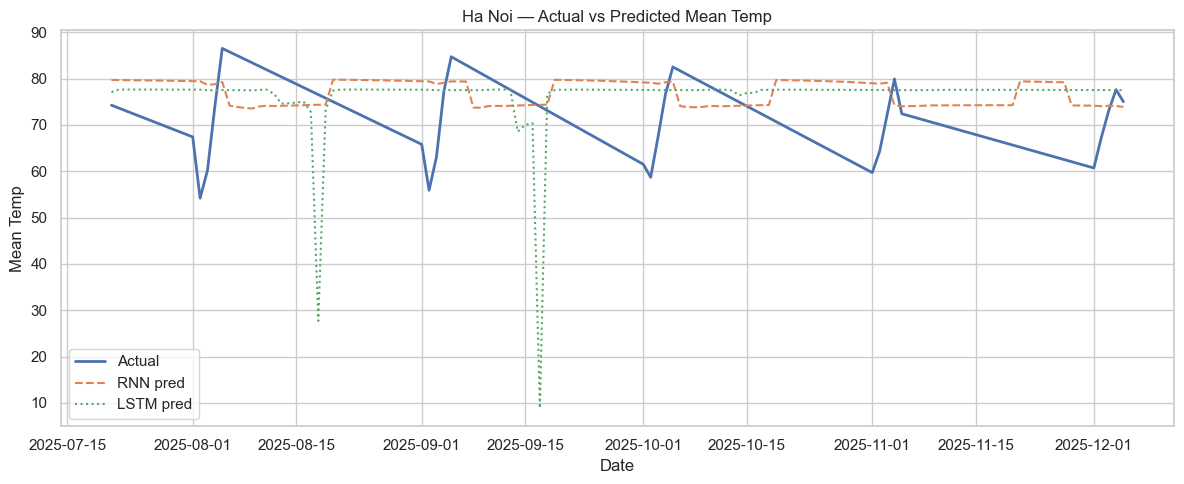

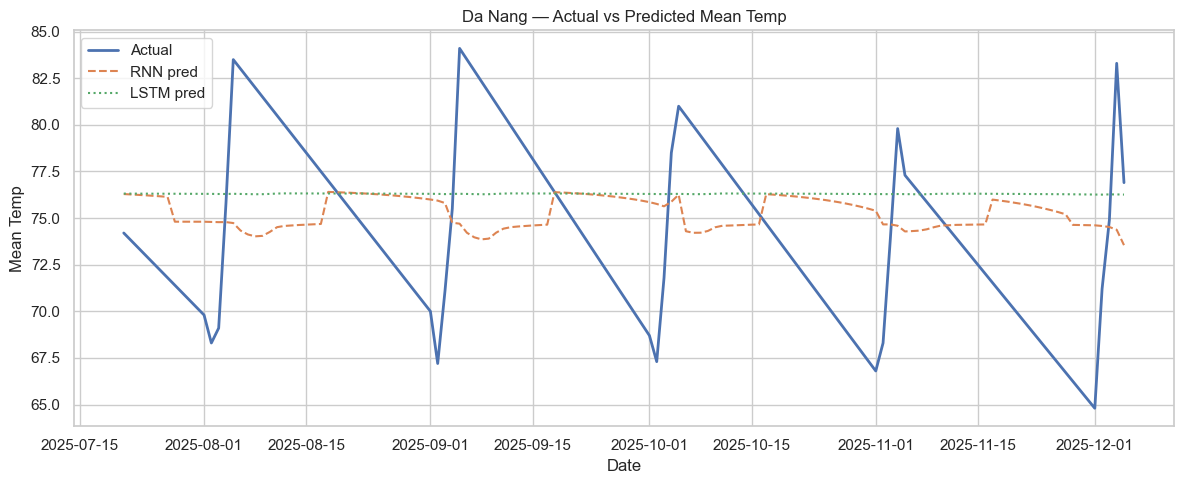

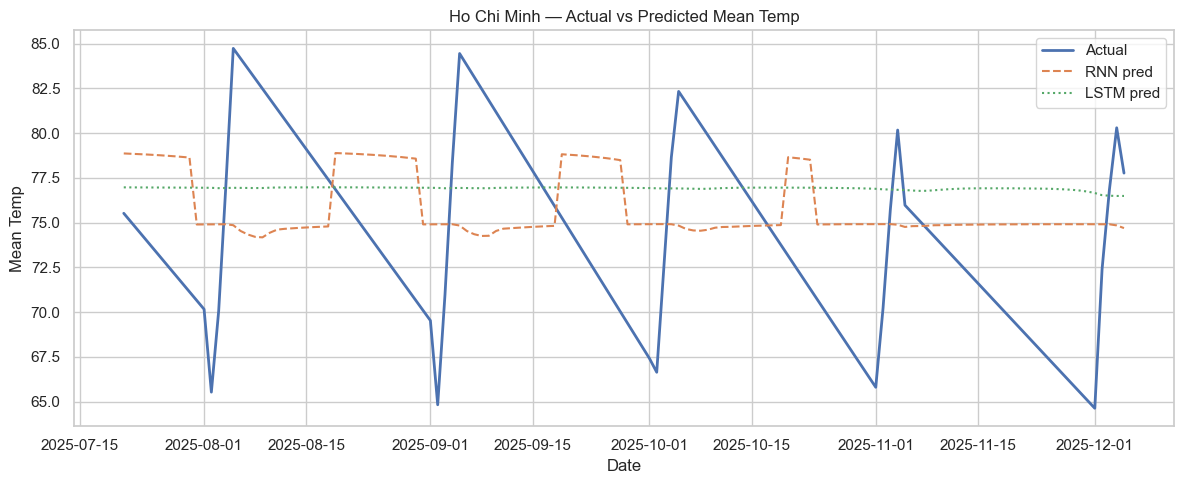


=== Summary metrics ===
                                                   RNN_metrics  \
Ha Noi       {'MAE': 8.66708580564274, 'MSE': 103.158666511...   
Da Nang      {'MAE': 4.481171757265581, 'MSE': 26.674595499...   
Ho Chi Minh  {'MAE': 5.225414049367163, 'MSE': 33.762037849...   

                                                  LSTM_metrics  
Ha Noi       {'MAE': 8.81213595274433, 'MSE': 136.144217787...  
Da Nang      {'MAE': 4.283530224729587, 'MSE': 25.795569084...  
Ho Chi Minh  {'MAE': 4.832767409428755, 'MSE': 32.757607133...  


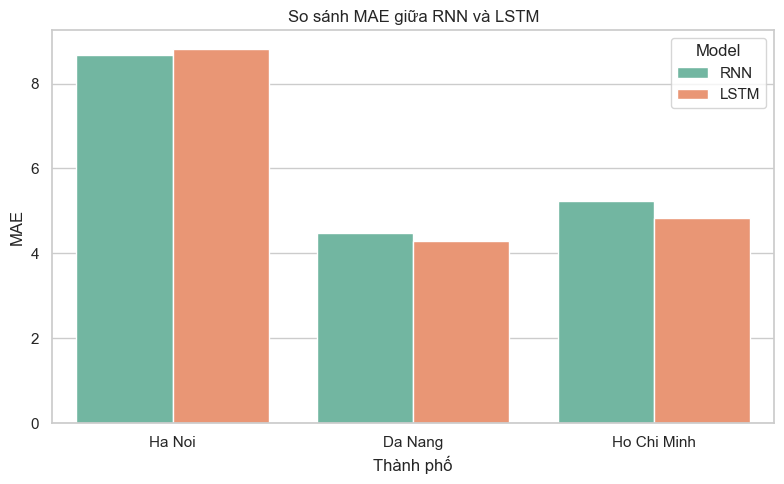

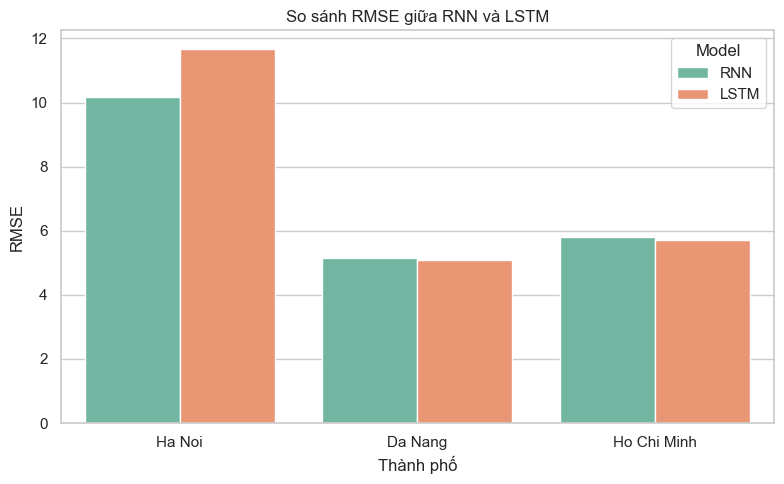

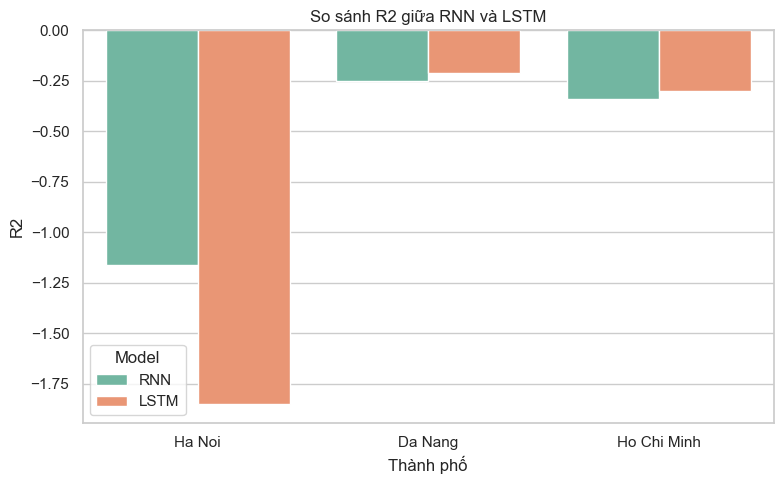

In [12]:
# ===========================
# BOX CODE (1 textbox) — Jupyter Notebook + Python 3.11.4 + TensorFlow
# Mục tiêu: Chuẩn hoá 3 file CSV thời tiết, xây RNN & LSTM để dự đoán nhiệt độ hàng ngày
# Dự đoán cho 3 khu vực: "Ha Noi", "Da Nang", "Ho Chi Minh"
# Lưu ý: bạn cần cài đặt môi trường trước khi chạy:
# pip install pandas numpy matplotlib scikit-learn tensorflow seaborn
# ===========================

# 1. Imports & config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

sns.set(style="whitegrid")

# ---------------------------
# 2. Paths to CSVs (chỉ 3 file)
# ---------------------------
path_w1 = "data_w1.csv"   # tiếng Việt, monthly
path_w2 = "data_w2.csv"   # english, monthly
path_w3 = "data_w3.csv"   # daily, nhiều cột (weatherapi-like)

# ---------------------------
# 3. Hỗ trợ: hàm chuẩn hoá từng file vào schema chung
# Schema chung (sau chuẩn hoá): ['date','location','min_temp','mean_temp','max_temp','precip_mm']
# ---------------------------

def load_and_normalize_w1(path):
    df = pd.read_csv(path, sep=None, engine='python')
    m_map = {
        "Tháng một":1, "Tháng hai":2, "Tháng ba":3, "Tháng bốn":4, "Tháng năm":5, "Tháng sáu":6,
        "Tháng bảy":7, "Tháng tám":8, "Tháng chín":9, "Tháng mười":10, "Tháng mười một":11, "Tháng mười hai":12
    }
    month_col = df.columns[0]
    df['month_num'] = df[month_col].map(m_map).fillna(df[month_col].str.extract('(\\d+)').astype(float)[0])
    if 'Giai đoạn' in df.columns:
        def mid_year(s):
            try:
                parts = str(s).split('-')
                return int((int(parts[0])+int(parts[-1]))/2)
            except:
                return 2000
        df['year'] = df['Giai đoạn'].apply(mid_year)
    else:
        df['year'] = 2000
    df['date'] = pd.to_datetime(df.apply(lambda r: f"{int(r['year'])}-{int(r['month_num']):02d}-01", axis=1))
    mapping = {}
    for c in df.columns:
        if 'Nhiệt độ thấp' in c or 'thấp nhất' in c:
            mapping[c] = 'min_temp'
        if 'Nhiệt độ trung' in c or 'trung bình' in c:
            mapping[c] = 'mean_temp'
        if 'Nhiệt độ cao' in c or 'cao nhất' in c:
            mapping[c] = 'max_temp'
        if 'Lượng mưa' in c or 'mưa' in c:
            mapping[c] = 'precip_mm'
    df = df.rename(columns=mapping)
    out = df[['date'] + [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in df.columns]].copy()
    out['location'] = 'Climatology'
    return out

def load_and_normalize_w2(path):
    df = pd.read_csv(path, sep=None, engine='python')
    month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    if 'Month' in df.columns:
        df['month_num'] = df['Month'].map(month_map).fillna(df['Month'].astype(str).str.extract('(\\d+)').astype(float)[0])
    if 'Period' in df.columns:
        def mid_year(s):
            try:
                parts = str(s).split('-')
                return int((int(parts[0])+int(parts[-1]))/2)
            except: return 2000
        df['year'] = df['Period'].apply(mid_year)
    else:
        df['year'] = 2000
    df['date'] = pd.to_datetime(df.apply(lambda r: f"{int(r['year'])}-{int(r['month_num']):02d}-01", axis=1))
    rename_map = {}
    for c in df.columns:
        if 'Min' in c and 'temp' in c: rename_map[c]='min_temp'
        if 'Mean' in c and 'temp' in c: rename_map[c]='mean_temp'
        if 'Max' in c and 'temp' in c: rename_map[c]='max_temp'
        if 'Precip' in c or 'rain' in c: rename_map[c]='precip_mm'
    df = df.rename(columns=rename_map)
    out = df[['date'] + [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in df.columns]].copy()
    out['location'] = 'Climatology'
    return out

def load_and_normalize_w3(path):
    df = pd.read_csv(path, sep=None, engine='python')
    if 'date' in df.columns:
        def try_parse(d):
            try:
                return pd.to_datetime(d, dayfirst=True)
            except:
                try:
                    return pd.to_datetime(d)
                except:
                    return pd.NaT
        df['date_parsed'] = df['date'].apply(try_parse)
    elif 'date_epoch' in df.columns:
        df['date_parsed'] = pd.to_datetime(df['date_epoch'], unit='s')
    else:
        df['date_parsed'] = pd.NaT
    loc_col = None
    for k in df.columns:
        if 'location.name' in k or 'location'==k:
            loc_col = k; break
    if loc_col not in df.columns:
        df['location'] = 'unknown'
    else:
        df['location'] = df[loc_col].astype(str)
    temps = {}
    for c in df.columns:
        if 'day.avgtemp' in c or 'day.avgtemp_c' in c: temps['mean_temp']=c
        if 'day.mintemp' in c: temps['min_temp']=c
        if 'day.maxtemp' in c: temps['max_temp']=c
        if 'day.totalprecip' in c: temps['precip_mm']=c
    out = pd.DataFrame()
    out['date'] = df['date_parsed']
    out['location'] = df['location']
    for k,v in temps.items():
        out[k] = pd.to_numeric(df[v], errors='coerce')
    out = out.dropna(subset=['date'])
    return out

# ---------------------------
# 4. Load all datasets
# ---------------------------
dfs = []
try:
    dfs.append(load_and_normalize_w1(path_w1))
except Exception as e:
    print("Warning load w1:", e)
try:
    dfs.append(load_and_normalize_w2(path_w2))
except Exception as e:
    print("Warning load w2:", e)
try:
    dfs.append(load_and_normalize_w3(path_w3))
except Exception as e:
    print("Warning load w3:", e)

if len(dfs)==0:
    raise RuntimeError("Không load được bất kỳ file dữ liệu nào. Hãy kiểm tra đường dẫn CSV.")

combined = pd.concat(dfs, ignore_index=True, sort=False)
combined['date'] = pd.to_datetime(combined['date'], errors='coerce')
combined = combined.dropna(subset=['date']).reset_index(drop=True)

# ---------------------------
# 5. Chuẩn hoá tên location và chọn 3 thành phố
# ---------------------------
def canonical_location(name):
    s = str(name).lower()
    if 'hanoi' in s or 'hà nội' in s or 'ha noi' in s:
        return 'Ha Noi'
    if 'da nang' in s or 'đà nẵng' in s:
        return 'Da Nang'
    if 'ho chi minh' in s or 'hcm' in s or 'thành phố hồ chí minh' or 'TP. Hồ Chí Minh' in s:
        return 'Ho Chi Minh'
    return name

combined['location_can'] = combined['location'].apply(canonical_location)

# ---------------------------
# 6. Tạo tập dữ liệu hàng ngày cho từng thành phố
# ---------------------------
targets = ['Ha Noi','Da Nang','Ho Chi Minh']
city_dfs = {}
for city in targets:
    dfc = combined[combined['location_can']==city].copy()
    if dfc.empty:
        print(f"Warning: không có dữ liệu cho {city}.")
        continue
    dfc = dfc.set_index('date').sort_index()
    cols_keep = [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in dfc.columns]
    dfc = dfc[cols_keep].resample('D').mean().interpolate(method='time').ffill().bfill()
    dfc['location'] = city
    city_dfs[city] = dfc.reset_index()

# ---------------------------
# 7. Hàm chuẩn bị dữ liệu cho mô hình
# ---------------------------
def prepare_supervised(df, target_col='mean_temp', lookback=14, test_ratio=0.2):
    df = df.copy().sort_values('date').reset_index(drop=True)
    if target_col not in df.columns:
        if {'min_temp','max_temp'}.issubset(df.columns):
            df[target_col] = df[['min_temp','max_temp']].mean(axis=1)
        else:
            raise RuntimeError("Không tìm thấy cột target để dự đoán.")
    df['dayofyear'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['rolling_mean_7'] = df[target_col].rolling(7, min_periods=1).mean()
    df['rolling_std_7'] = df[target_col].rolling(7, min_periods=1).std().fillna(0)
    seq_X, seq_y, dates = [], [], []
    for i in range(lookback, len(df)):
        window = df.iloc[i-lookback:i]
        feat = window[[target_col,'rolling_mean_7','rolling_std_7','dayofyear','month']].values
        seq_X.append(feat)
        seq_y.append(df.iloc[i][target_col])
        dates.append(df.iloc[i]['date'])
    X, y = np.array(seq_X), np.array(seq_y)
    split = int(len(X)*(1-test_ratio))
    return X[:split], X[split:], y[:split], y[split:], dates[:split], dates[split:]

# ---------------------------
# 8. Scaling
# ---------------------------
def scale_sequences(X_train, X_test):
    n_samples, lookback, n_features = X_train.shape
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, n_features)
    X_test_flat = X_test.reshape(-1, n_features)
    scaler.fit(X_train_flat)
    X_train_s = scaler.transform(X_train_flat).reshape(n_samples, lookback, n_features)
    X_test_s = scaler.transform(X_test_flat).reshape(X_test.shape[0], lookback, n_features)
    return X_train_s, X_test_s, scaler

# ---------------------------
# 9. Xây model RNN & LSTM
# ---------------------------
def build_rnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.SimpleRNN(64, activation='tanh'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_lstm_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ---------------------------
# 10. Train & Evaluate
# ---------------------------
results = {}
lookback = 14
EPOCHS = 30
BATCH = 32

for city, dfc in city_dfs.items():
    print(f"\n=== Processing city: {city} ===")
    X_tr, X_te, y_tr, y_te, dates_tr, dates_te = prepare_supervised(dfc, lookback=lookback, test_ratio=0.2)
    if len(X_tr)==0:
        print(f"Insufficient data for {city}.")
        continue
    X_tr_s, X_te_s, scaler = scale_sequences(X_tr, X_te)
    input_shape = X_tr_s.shape[1:]

    rnn_model = build_rnn_model(input_shape)
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    hist_rnn = rnn_model.fit(X_tr_s, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=0)

    lstm_model = build_lstm_model(input_shape)
    es2 = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    hist_lstm = lstm_model.fit(X_tr_s, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH, callbacks=[es2], verbose=0)

    ypred_rnn = rnn_model.predict(X_te_s).flatten()
    ypred_lstm = lstm_model.predict(X_te_s).flatten()

    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return {'MAE':mae, 'MSE':mse, 'RMSE':rmse, 'R2':r2}

    met_rnn = metrics(y_te, ypred_rnn)
    met_lstm = metrics(y_te, ypred_lstm)

    # lỗi do ở phần dictionary key 'history"' bị gõ nhầm dấu ngoặc kép.
# Thay 'history": hist_lstm.history' -> 'history': hist_lstm.history

    results[city] = {
        'rnn': {
            'model': rnn_model,
            'history': hist_rnn.history,
            'metrics': met_rnn,
            'y_true': y_te,
            'y_pred': ypred_rnn,
            'dates': dates_te
        },
        'lstm': {
            'model': lstm_model,
            'history': hist_lstm.history,  # ✅ sửa lỗi tại đây
            'metrics': met_lstm,
            'y_true': y_te,
            'y_pred': ypred_lstm,
            'dates': dates_te
        },
        'scaler': scaler
    }

    print(f"City {city} done. RNN MAE={met_rnn['MAE']:.3f}, LSTM MAE={met_lstm['MAE']:.3f}")

# ---------------------------
# 11. Visualization
# ---------------------------
def plot_results_for_city(city, res_dict):
    r = res_dict['rnn']
    l = res_dict['lstm']
    dates = pd.to_datetime(r['dates'])
    y_true = r['y_true']
    y_rnn = r['y_pred']
    y_lstm = l['y_pred']
    plt.figure(figsize=(12,5))
    plt.plot(dates, y_true, label='Actual', linewidth=2)
    plt.plot(dates, y_rnn, label='RNN pred', linestyle='--')
    plt.plot(dates, y_lstm, label='LSTM pred', linestyle=':')
    plt.title(f"{city} — Actual vs Predicted Mean Temp")
    plt.xlabel('Date'); plt.ylabel('Mean Temp'); plt.legend(); plt.tight_layout(); plt.show()

for city, res in results.items():
    plot_results_for_city(city, res)

# ---------------------------
# 12. Save results
# ---------------------------
out_summary = {}
for city,res in results.items():
    out_summary[city] = {
        'RNN_metrics': res['rnn']['metrics'],
        'LSTM_metrics': res['lstm']['metrics']
    }

summary_df = pd.DataFrame.from_dict(out_summary, orient='index')
print("\n=== Summary metrics ===")
print(summary_df)

# ---------------------------
# 13. Visualization: So sánh độ chính xác giữa RNN & LSTM
# ---------------------------
metrics_names = ['MAE', 'RMSE', 'R2']

# Tạo DataFrame chứa tất cả metric của cả RNN và LSTM
plot_data = []
for city, res in results.items():
    for model_name in ['rnn', 'lstm']:
        met = res[model_name]['metrics']
        plot_data.append({
            'City': city,
            'Model': model_name.upper(),
            'MAE': met['MAE'],
            'RMSE': met['RMSE'],
            'R2': met['R2']
        })

df_plot = pd.DataFrame(plot_data)

# Vẽ biểu đồ cột so sánh từng metric
for metric in metrics_names:
    plt.figure(figsize=(8,5))
    sns.barplot(data=df_plot, x='City', y=metric, hue='Model', palette='Set2')
    plt.title(f"So sánh {metric} giữa RNN và LSTM")
    plt.ylabel(metric)
    plt.xlabel("Thành phố")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()



In [15]:
# ===========================
# BOX CODE — Jupyter Notebook + Python 3.11.4 + TensorFlow
# Mục tiêu: Chuẩn hoá 3 file CSV thời tiết, xây RNN & LSTM để dự đoán nhiệt độ hàng ngày
# Khu vực: "Ha Noi", "Da Nang", "Ho Chi Minh"
# Cài đặt môi trường:
# pip install pandas numpy matplotlib scikit-learn tensorflow seaborn
# ===========================

# 1. Imports & Config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

sns.set(style="whitegrid")

# ---------------------------
# 2. Đường dẫn CSV (3 file)
# ---------------------------
path_w1 = "data_w1.csv"   # Vietnamese - monthly
dpath_w2 = "data_w2.csv"   # English - monthly
path_w3 = "data_w3.csv"   # Daily (weatherapi-like)

# ---------------------------
# 3. Hàm chuẩn hoá dữ liệu về schema chung
# Schema: ['date','location','min_temp','mean_temp','max_temp','precip_mm']
# ---------------------------

def load_and_normalize_w1(path):
    df = pd.read_csv(path, sep=None, engine='python')
    m_map = {
        "Tháng một":1, "Tháng hai":2, "Tháng ba":3, "Tháng bốn":4, "Tháng năm":5, "Tháng sáu":6,
        "Tháng bảy":7, "Tháng tám":8, "Tháng chín":9, "Tháng mười":10, "Tháng mười một":11, "Tháng mười hai":12
    }
    df['month_num'] = df[df.columns[0]].map(m_map).fillna(df[df.columns[0]].str.extract('(\\d+)').astype(float)[0])
    if 'Giai đoạn' in df.columns:
        df['year'] = df['Giai đoạn'].apply(lambda s: int(np.mean([int(x) for x in str(s).split('-') if x.isdigit()])) if '-' in str(s) else 2000)
    else:
        df['year'] = 2000
    df['date'] = pd.to_datetime(df.apply(lambda r: f"{int(r['year'])}-{int(r['month_num']):02d}-01", axis=1))

    mapping = {}
    for c in df.columns:
        if 'thấp' in c: mapping[c] = 'min_temp'
        if 'trung bình' in c: mapping[c] = 'mean_temp'
        if 'cao' in c: mapping[c] = 'max_temp'
        if 'mưa' in c: mapping[c] = 'precip_mm'

    df = df.rename(columns=mapping)
    out = df[['date'] + [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in df.columns]].copy()
    out['location'] = 'Climatology'
    return out

def load_and_normalize_w2(path):
    df = pd.read_csv(path, sep=None, engine='python')
    month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    df['month_num'] = df['Month'].map(month_map).fillna(df['Month'].astype(str).str.extract('(\\d+)').astype(float)[0]) if 'Month' in df.columns else 1
    if 'Period' in df.columns:
        df['year'] = df['Period'].apply(lambda s: int(np.mean([int(x) for x in str(s).split('-') if x.isdigit()])) if '-' in str(s) else 2000)
    else:
        df['year'] = 2000
    df['date'] = pd.to_datetime(df.apply(lambda r: f"{int(r['year'])}-{int(r['month_num']):02d}-01", axis=1))

    rename_map = {c: ('min_temp' if 'Min' in c else 'mean_temp' if 'Mean' in c else 'max_temp' if 'Max' in c else 'precip_mm') for c in df.columns if 'temp' in c or 'Precip' in c}
    df = df.rename(columns=rename_map)
    out = df[['date'] + [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in df.columns]].copy()
    out['location'] = 'Climatology'
    return out

def load_and_normalize_w3(path):
    df = pd.read_csv(path, sep=None, engine='python')
    if 'date' in df.columns:
        df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
    elif 'date_epoch' in df.columns:
        df['date_parsed'] = pd.to_datetime(df['date_epoch'], unit='s')
    else:
        df['date_parsed'] = pd.NaT

    loc_col = next((k for k in df.columns if 'location.name' in k or k == 'location'), None)
    df['location'] = df[loc_col].astype(str) if loc_col else 'unknown'

    temp_map = {k:v for k,v in zip(['mean_temp','min_temp','max_temp','precip_mm'], [c for c in df.columns if any(x in c for x in ['avgtemp','mintemp','maxtemp','precip'])])}

    out = pd.DataFrame({'date': df['date_parsed'], 'location': df['location']})
    for k,v in temp_map.items():
        out[k] = pd.to_numeric(df[v], errors='coerce')
    return out.dropna(subset=['date'])

# ---------------------------
# 4. Load tất cả datasets
# ---------------------------
all_dfs = []
for func, path in [(load_and_normalize_w1, path_w1), (load_and_normalize_w2, path_w2), (load_and_normalize_w3, path_w3)]:
    try:
        all_dfs.append(func(path))
    except Exception as e:
        print(f"Warning when loading {path}: {e}")

if not all_dfs:
    raise RuntimeError("Không load được bất kỳ file dữ liệu nào.")

combined = pd.concat(all_dfs, ignore_index=True).dropna(subset=['date'])
combined['date'] = pd.to_datetime(combined['date'], errors='coerce')

# ---------------------------
# 5. Chuẩn hoá tên địa điểm
# ---------------------------
def canonical_location(name):
    s = str(name).lower()
    if 'hanoi' in s or 'hà nội' in s: return 'Ha Noi'
    if 'da nang' in s or 'đà nẵng' in s: return 'Da Nang'
    if any(x in s for x in ['ho chi minh','hcm','thành phố hồ chí minh', 'TP. Hồ Chí Minh']): return 'Ho Chi Minh'
    return name

combined['location_can'] = combined['location'].apply(canonical_location)

# ---------------------------
# 6. Tạo tập dữ liệu hàng ngày cho từng thành phố
# ---------------------------
cities = ['Ha Noi','Da Nang','Ho Chi Minh']
city_dfs = {}
for city in cities:
    dfc = combined[combined['location_can']==city].copy()
    if dfc.empty:
        print(f"⚠️ Không có dữ liệu cho {city}.")
        continue
    dfc = dfc.set_index('date').sort_index()
    cols = [c for c in ['min_temp','mean_temp','max_temp','precip_mm'] if c in dfc.columns]
    dfc = dfc[cols].resample('D').mean().interpolate('time').ffill().bfill()
    dfc['location'] = city
    city_dfs[city] = dfc.reset_index()

# ---------------------------
# 7. Hàm chuẩn bị dữ liệu supervised learning
# ---------------------------
def prepare_supervised(df, target_col='mean_temp', lookback=14, test_ratio=0.2):
    df = df.sort_values('date').reset_index(drop=True)
    if target_col not in df.columns:
        df[target_col] = df[['min_temp','max_temp']].mean(axis=1)

    df['dayofyear'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['rolling_mean_7'] = df[target_col].rolling(7, min_periods=1).mean()
    df['rolling_std_7'] = df[target_col].rolling(7, min_periods=1).std().fillna(0)

    X, y, dates = [], [], []
    for i in range(lookback, len(df)):
        X.append(df.iloc[i-lookback:i][[target_col,'rolling_mean_7','rolling_std_7','dayofyear','month']].values)
        y.append(df.iloc[i][target_col])
        dates.append(df.iloc[i]['date'])

    X, y = np.array(X), np.array(y)
    split = int(len(X)*(1-test_ratio))
    return X[:split], X[split:], y[:split], y[split:], dates[:split], dates[split:]

# Kiểm tra dữ liệu đầu vào có vấn đề ở thành phố Hồ Chí Minh không
import pandas as pd

# Giả sử bạn đã có df gốc
# Hãy in ra danh sách unique các tên thành phố
print("Các tên thành phố có trong dữ liệu:")
print(df['Location'].unique())

# Kiểm tra có khác biệt về cách viết (ví dụ: 'Ho Chi Minh', 'Hồ Chí Minh', 'Ho Chi Minh City')
# Ta có thể lọc thử:
mask = df['Location'].str.contains('Hồ|Ho', case=False, na=False)
print(df[mask]['Location'].value_counts())

# Nếu cần xem dữ liệu mẫu của Hồ Chí Minh:
print("Dữ liệu mẫu của Hồ Chí Minh:")
print(df[df['Location'].str.contains('Hồ Chí Minh', case=False, na=False)].head())

# ---------------------------
# 8. Chuẩn hoá dữ liệu bằng StandardScaler
# ---------------------------
def scale_sequences(X_train, X_test):
    n_samples, lookback, n_features = X_train.shape
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples, lookback, n_features)
    X_test_s = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape[0], lookback, n_features)
    return X_train_s, X_test_s, scaler

# ---------------------------
# 9. Định nghĩa mô hình RNN & LSTM
# ---------------------------
def build_rnn_model(shape):
    model = models.Sequential([
        layers.Input(shape=shape),
        layers.SimpleRNN(64, activation='tanh'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_lstm_model(shape):
    model = models.Sequential([
        layers.Input(shape=shape),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ---------------------------
# 10. Train & Evaluate Models
# ---------------------------
results, lookback, EPOCHS, BATCH = {}, 14, 30, 32

for city, dfc in city_dfs.items():
    print(f"\n=== Training for {city} ===")
    X_tr, X_te, y_tr, y_te, d_tr, d_te = prepare_supervised(dfc, lookback=lookback)
    if len(X_tr)==0: continue
    X_tr_s, X_te_s, scaler = scale_sequences(X_tr, X_te)
    shape = X_tr_s.shape[1:]

    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    rnn = build_rnn_model(shape)
    lstm = build_lstm_model(shape)

    h_rnn = rnn.fit(X_tr_s, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=0)
    h_lstm = lstm.fit(X_tr_s, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=0)

    y_rnn, y_lstm = rnn.predict(X_te_s).flatten(), lstm.predict(X_te_s).flatten()

    def metrics(y_true, y_pred):
        return {
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'R2': r2_score(y_true, y_pred)
        }

    results[city] = {
        'rnn': {'model': rnn, 'history': h_rnn.history, 'metrics': metrics(y_te, y_rnn), 'y_true': y_te, 'y_pred': y_rnn, 'dates': d_te},
        'lstm': {'model': lstm, 'history': h_lstm.history, 'metrics': metrics(y_te, y_lstm), 'y_true': y_te, 'y_pred': y_lstm, 'dates': d_te},
        'scaler': scaler
    }

    print(f"✅ {city}: RNN MAE={results[city]['rnn']['metrics']['MAE']:.3f}, LSTM MAE={results[city]['lstm']['metrics']['MAE']:.3f}")

# ---------------------------
# 11. Visualization: Actual vs Predicted
# ---------------------------
def plot_city_results(city, res):
    plt.figure(figsize=(12,5))
    plt.plot(res['rnn']['dates'], res['rnn']['y_true'], label='Actual', linewidth=2)
    plt.plot(res['rnn']['dates'], res['rnn']['y_pred'], '--', label='RNN')
    plt.plot(res['lstm']['dates'], res['lstm']['y_pred'], ':', label='LSTM')
    plt.title(f"{city} — Actual vs Predicted Mean Temperature")
    plt.xlabel('Date'); plt.ylabel('Mean Temp (°C)'); plt.legend(); plt.tight_layout(); plt.show()

for city, res in results.items():
    plot_city_results(city, res)

# ---------------------------
# 12. Tổng hợp kết quả
# ---------------------------
summary = pd.DataFrame({city: {
    'RNN_MAE': results[city]['rnn']['metrics']['MAE'],
    'LSTM_MAE': results[city]['lstm']['metrics']['MAE'],
    'RNN_R2': results[city]['rnn']['metrics']['R2'],
    'LSTM_R2': results[city]['lstm']['metrics']['R2']
} for city in results}).T

print("\n=== Summary Metrics ===")
print(summary)

# ---------------------------
# 13. So sánh trực quan giữa RNN và LSTM
# ---------------------------
metrics_names = ['MAE', 'RMSE', 'R2']
plot_data = []

for city, res in results.items():
    for model in ['rnn', 'lstm']:
        m = res[model]['metrics']
        plot_data.append({'City': city, 'Model': model.upper(), 'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2']})

df_plot = pd.DataFrame(plot_data)

for metric in metrics_names:
    plt.figure(figsize=(8,5))
    sns.barplot(data=df_plot, x='City', y=metric, hue='Model', palette='Set2')
    plt.title(f'So sánh {metric} giữa RNN và LSTM')
    plt.ylabel(metric)
    plt.xlabel('Thành phố')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()


Warning when loading data_w1.csv: cannot convert float NaN to integer
⚠️ Không có dữ liệu cho Ho Chi Minh.
Các tên thành phố có trong dữ liệu:


KeyError: 'Location'